In [1]:
# Need to install rpy2 and have a version of R on computer with package LatticeKrig and dependencies installed

import rpy2
print(rpy2.__version__)

3.5.8


In [2]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

packnames = ('ggplot2', 'spam64')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

by .GlobalEnv when processing object ‘G’


In [3]:
# Function to load cifti data 

import nibabel as nb
import numpy as np
 
# cifti code based on Christopher J Markiewicz https://nbviewer.jupyter.org/github/neurohackademy/nh2020-curriculum/blob/master/we-nibabel-markiewicz/NiBabel.ipynb
# load cifti file containing the vertexwise values, in this case myelin map from the HCP
cifti = nb.load('/Users/robleech/Dropbox/HCP_S900_GroupAvg_v1/HCP_S900_787_tfMRI_ALLTASKS_level3_zstat1_hp200_s2_MSMSulc.dscalar.nii')
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr = cifti.header
nifti_hdr = cifti.nifti_header

axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]

def surf_data_from_cifti(data, axis, surf_name): 
    assert isinstance(axis, nb.cifti2.BrainModelAxis)
    for name, data_indices, model in axis.iter_structures():  # Iterates over volumetric and surface structures
        if name == surf_name:                                 # Just looking for a surface
            data = data.T[data_indices]                       # Assume brainmodels axis is last, move it to front
            vtx_indices = model.vertex                        # Generally 1-N, except medial wall vertices
            surf_data = np.zeros((vtx_indices.max() + 1,) + data.shape[1:], dtype=data.dtype)
            surf_data[vtx_indices] = data
            return surf_data
    raise ValueError(f"No structure named {surf_name}")

left_brain=surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')

#load gifti spherical surface that is the same resolution/underlying mesh etc as the cifti 
gifti_img_BaseBrain = nb.load('/Users/robleech/Dropbox/BrainSmash/S900.L.sphere.32k_fs_LR.surf.gii')

xyz_points=gifti_img_BaseBrain.darrays[0].data


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
# Calculate spherical (S2) coordinates from eulidean vertex locations (R3) on spherical surface
import numpy as np

def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    #ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

ptsnew=appendSpherical_np(xyz_points)

In [6]:
import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
from rpy2.robjects import r, pandas2ri
import pandas as pd
import scipy
#from sklearn.neighbors import DistanceMetric

pandas2ri.activate()
LK = importr('LatticeKrig')
cifti = nb.load('/Users/robleech/Dropbox/HCP_S900_GroupAvg_v1/HCP_S900_787_tfMRI_ALLTASKS_level3_zstat1_hp200_s2_MSMSulc.dscalar.nii')
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr = cifti.header
nifti_hdr = cifti.nifti_header

axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
left_brain=surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')

taskNames=np.loadtxt('/Users/robleech/Dropbox/BrainSmash/TaskNames.txt',dtype=str,delimiter=',')
tasks=np.asarray([9,31,42,62,69,74,80])

LKPredAllTasks=np.zeros([ptsnew.shape[0],tasks.shape[0]])
AllThresh=np.zeros([7])

count=0
for i in range(tasks.shape[0]):

        task=tasks[i]
        threshUpper= np.percentile(left_brain[:,task], 75, axis=0)
        threshLower= np.percentile(left_brain[:,task], 25, axis=0)
        #threshUpper=10
        AllThresh[i]=threshUpper

        pos_index=left_brain[:,task]>threshUpper
        neg_index=left_brain[:,task]<threshLower

        X_temp=np.degrees(ptsnew[pos_index,4])

        X1=FloatVector(X_temp[:])

        X_temp=np.degrees(ptsnew[pos_index,5])
        #X2=FloatVector(X_temp[rndChoice])
        X2=FloatVector(X_temp[:])
        Y_temp=left_brain[pos_index,task]
        #Y=FloatVector(Y_temp[rndChoice])
        Y=FloatVector(Y_temp[:])

        df = pd.DataFrame({'X1': X2, 'X2': X1})

        r_dataframe = pandas2ri.py2rpy(df)

        alpha=FloatVector(np.power([1,0.5,0.1],2))

        LKinfo=LK.LKrigSetup(r_dataframe,startingLevel=3,nlevel=3,a_wght=1.01,alpha=alpha,LKGeometry="LKSphere",Radius=100) 

        LKOutput=LK.LatticeKrig(r_dataframe,Y,LKinfo=LKinfo)

        X1_all=FloatVector(np.degrees(ptsnew[:,4]))
        X2_all=FloatVector(np.degrees(ptsnew[:,5]))
        Y_all=FloatVector(left_brain[:,task])




        df_all = pd.DataFrame({'X1': X2_all, 'X2': X1_all})

        r_dataframe_all = pandas2ri.py2rpy(df_all)
        LKPredAllTasks[:,count]=r.predict(LKOutput,r_dataframe_all).ravel()
        count=count+1
        

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [7]:
np.save('LKPredAllTasksNeg',LKPredAllTasks) # save out the predictions for all tasks for use elsewher.e.


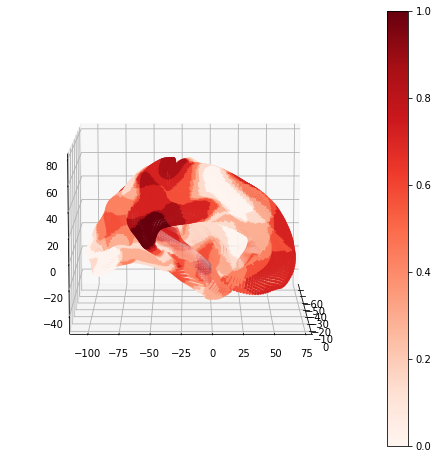

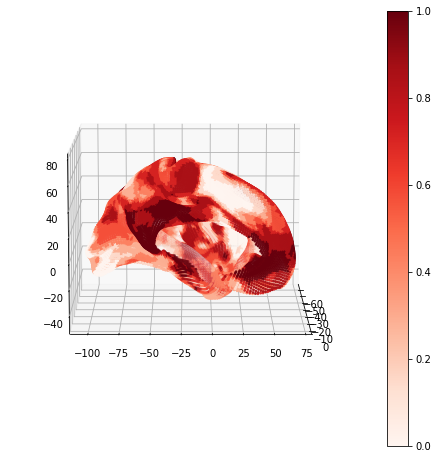

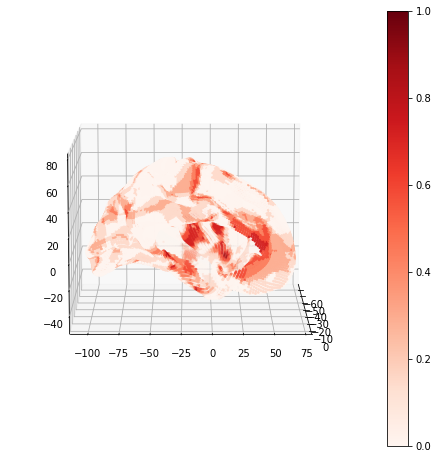

In [19]:
# Quick visualisation of overlap maps for real and predicted overlap of task vertices with <0 activity

import matplotlib.pyplot as plt

gifti_img_Midthickness = nb.load('S900.L.midthickness_MSMAll.32k_fs_LR.surf.gii')
xyz_points_Mid=gifti_img_Midthickness.darrays[0].data
azim=0

TPProj=(LKPredAllTasks<0).mean(axis=1)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
#p=ax.scatter(xyz_points[:,0],xyz_points[:,1],xyz_points[:,2],c=LKpred_all,s=3,cmap='bwr',vmin=-10,vmax=10)
p=ax.scatter(xyz_points_Mid[np.abs(left_brain[:,0])>0,0],xyz_points_Mid[np.abs(left_brain[:,0])>0,1],xyz_points_Mid[np.abs(left_brain[:,0])>0,2],c=TPProj[np.abs(left_brain[:,0])>0],s=3,cmap='Reds',vmin=0,vmax=1)
ax.view_init(elev=10., azim=azim)
fig.colorbar(p,ax=ax)

TPReal=(left_brain[:,tasks]<0).mean(axis=1)
TPReal_NoMedialWall=np.where(TPReal==0,0,TPReal)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
#p=ax.scatter(xyz_points[:,0],xyz_points[:,1],xyz_points[:,2],c=LKpred_all,s=3,cmap='bwr',vmin=-10,vmax=10)
p=ax.scatter(xyz_points_Mid[np.abs(left_brain[:,0])>0,0],xyz_points_Mid[np.abs(left_brain[:,0])>0,1],xyz_points_Mid[np.abs(left_brain[:,0])>0,2],c=TPReal[np.abs(left_brain[:,0])>0],s=3,cmap='Reds',vmin=0,vmax=1)
ax.view_init(elev=10., azim=azim)
fig.colorbar(p,ax=ax)

#fig = plt.figure(figsize=(8, 8))
#plt.scatter(TPReal,TPProj)
#plt.colorbar()


TPProj_NoMedialWall=np.where(TPReal==0,0,TPProj)
np.corrcoef(TPReal[YeoDMN==0],TPProj[YeoDMN==0])


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
#p=ax.scatter(xyz_points[:,0],xyz_points[:,1],xyz_points[:,2],c=LKpred_all,s=3,cmap='bwr',vmin=-10,vmax=10)
p=ax.scatter(xyz_points_Mid[np.abs(left_brain[:,0])>0,0],xyz_points_Mid[np.abs(left_brain[:,0])>0,1],xyz_points_Mid[np.abs(left_brain[:,0])>0,2],c=TPReal[np.abs(left_brain[:,0])>0]-TPProj[np.abs(left_brain[:,0])>0],s=3,cmap='Reds',vmin=0,vmax=1)
ax.view_init(elev=10., azim=azim)
fig.colorbar(p,ax=ax)


In [ ]:
TaskTaskCorr=np.zeros([7,7])


from scipy import stats
num_tasks=tasks.shape[0]
fig, axes = plt.subplots(1,num_tasks, figsize=(5.5* num_tasks , 5))
count=0
for taskID, task in enumerate(tasks):
    threshUpper= np.percentile(left_brain[:,task], 75, axis=0)
    

    pos_index=left_brain[:,task]>threshUpper
    neg_index=left_brain[:,task]<threshUpper

    ax = axes[count]
    clust_data = np.ravel(LKPredAllTasks[neg_index, taskID])*-1
    task_data = np.ravel(left_brain[neg_index, task])*-1
    s_r=format(stats.spearmanr(clust_data,task_data)[0], '.2f')
    df = pd.DataFrame({"LKPredAllTasks": clust_data*-1, "left_brain": task_data*-1})
    sns.kdeplot(data=df, x="LKPredAllTasks", y="left_brain",fill=True,ax=ax,cmap="bone_r")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    ax.set_title(f"Task {taskNames[tasks[taskID]]} Correlation {s_r}")

    count=count+1

plt.savefig('EachTaskScatterRealPred_lt_75pcPredNeg.png')
    
fig2, axes = plt.subplots(1,num_tasks, figsize=(5.5 * num_tasks, 5))
count=0
for taskID, task in enumerate(tasks):
    
    #threshLower= np.percentile(left_brain[:,task], 50, axis=0)
    neg_index=left_brain[:,task]<0
    
    
    ax = axes[count]
    clust_data = np.ravel(LKPredAllTasks[neg_index, taskID])
    task_data = np.ravel(left_brain[neg_index, task])
    s_r=format(stats.spearmanr(clust_data,task_data)[0], '.2f')
    df = pd.DataFrame({"LKPredAllTasks": clust_data, "left_brain": task_data})
    sns.kdeplot(data=df, x="LKPredAllTasks", y="left_brain",fill=True,ax=ax,cmap="bone_r")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    ax.set_title(f"Task {taskNames[tasks[taskID]]} Correlation {s_r}")

    count=count+1

plt.savefig('EachTaskScatterRealPred_ltPreNeg_0.png')



In [22]:
# Code for writing out .ply images with matplotlib defined colormap for visualisation in e.g., Blender

def write_plyRGB(filename, vertices, faces, colorsR,colorsG,colorsB,comment=None):
    import pandas as pd
    print("writing ply format")
    # infer number of vertices and faces
    number_vertices = vertices.shape[0]
    number_faces = faces.shape[0]
    # make header dataframe
    header = ['ply',
            'format ascii 1.0',
            'comment %s' % comment,
            'element vertex %i' % number_vertices,
            'property float x',
            'property float y',
            'property float z',
            'property uchar red',
            'property uchar green',
            'property uchar blue',
            'element face %i' % number_faces,
            'property list uchar int vertex_indices',
            'end_header'
             ]
    header_df = pd.DataFrame(header)
    # make dataframe from vertices
    vertex_df = pd.DataFrame(vertices/50)
    #colors_df = pd.DataFrame(np.tile(np.round(colors/7*255), (3,1)).T)
    ColorsR_df=pd.DataFrame(colorsR)
    ColorsG_df=pd.DataFrame(colorsG)
    ColorsB_df=pd.DataFrame(colorsB)
    colorsConcat = pd.concat([ColorsR_df,ColorsG_df,ColorsB_df], axis=1)
    colors_df=pd.DataFrame(colorsConcat)
    colors_df=colorsConcat.astype(int)
    df_concat = pd.concat([vertex_df, colors_df], axis=1)
    # make dataframe from faces, adding first row of 3s (indicating triangles)
    triangles = np.reshape(3 * (np.ones(number_faces)), (number_faces, 1))
    triangles = triangles.astype(int)
    faces = faces.astype(int)
    faces_df = pd.DataFrame(np.concatenate((triangles, faces), axis=1))
    # write dfs to csv
    header_df.to_csv(filename, header=None, index=False)
    with open(filename, 'a') as f:
        df_concat.to_csv(f, header=False, index=False,
                         float_format='%.3f', sep=' ')
    with open(filename, 'a') as f:
        faces_df.to_csv(f, header=False, index=False,
                        float_format='%.0f', sep=' ')

In [25]:
# Write out .ply files with masked, real and predicted activity for visualisation with e.g., Blender

cmap = matplotlib.cm.get_cmap('coolwarm')

for i, task in enumerate(tasks):
    vertices=gifti_img_Midthickness.darrays[0].data
    faces=gifti_img_Midthickness.darrays[1].data    
    print(task)
    print(taskNames[task])
    
    colors=left_brain[:,task]
    #tempColors=np.where(TPReal==0,0,colors)
    norm = matplotlib.colors.Normalize(vmin=-20, vmax=20)
    CMap=cmap(norm(colors))*255
    PlyFileName='TNTaskActivity' + taskNames[task] + '.ply'
    write_plyRGB(PlyFileName,vertices,faces,CMap[:,0],CMap[:,1],CMap[:,2])
 
    colors=np.zeros(left_brain[:,task].shape)
    colors[left_brain[:,task]>AllThresh[i]]=left_brain[left_brain[:,task]>AllThresh[i],task]
    norm = matplotlib.colors.Normalize(vmin=-20, vmax=20)
    CMap=cmap(norm(colors))*255
    PlyFileName='TNThresholded' + taskNames[task] + '.ply'
    write_plyRGB(PlyFileName,vertices,faces,CMap[:,0],CMap[:,1],CMap[:,2])

    
    tempColors=np.where(left_brain[:,task]==0,0,LKPredAllTasks[:,i])
    #colors=LKPredAllTasks[:,i]
    colors=tempColors.copy()
    norm = matplotlib.colors.Normalize(vmin=-20, vmax=20)
    CMap=cmap(norm(colors))*255
    PlyFileName='TNProjected' + taskNames[task] + '.ply'
    write_plyRGB(PlyFileName,vertices,faces,CMap[:,0],CMap[:,1],CMap[:,2])



9
tfMRI_WM_0BK
writing ply format
writing ply format
writing ply format
31
tfMRI_GAMBLING_REWARD
writing ply format
writing ply format
writing ply format
42
tfMRI_MOTOR_AVG
writing ply format
writing ply format
writing ply format
62
tfMRI_LANGUAGE_MATH
writing ply format
writing ply format
writing ply format
69
tfMRI_SOCIAL_TOM
writing ply format
writing ply format
writing ply format
74
tfMRI_RELATIONAL_MATCH
writing ply format
writing ply format
writing ply format
80
tfMRI_EMOTION_FACES
writing ply format
writing ply format
writing ply format


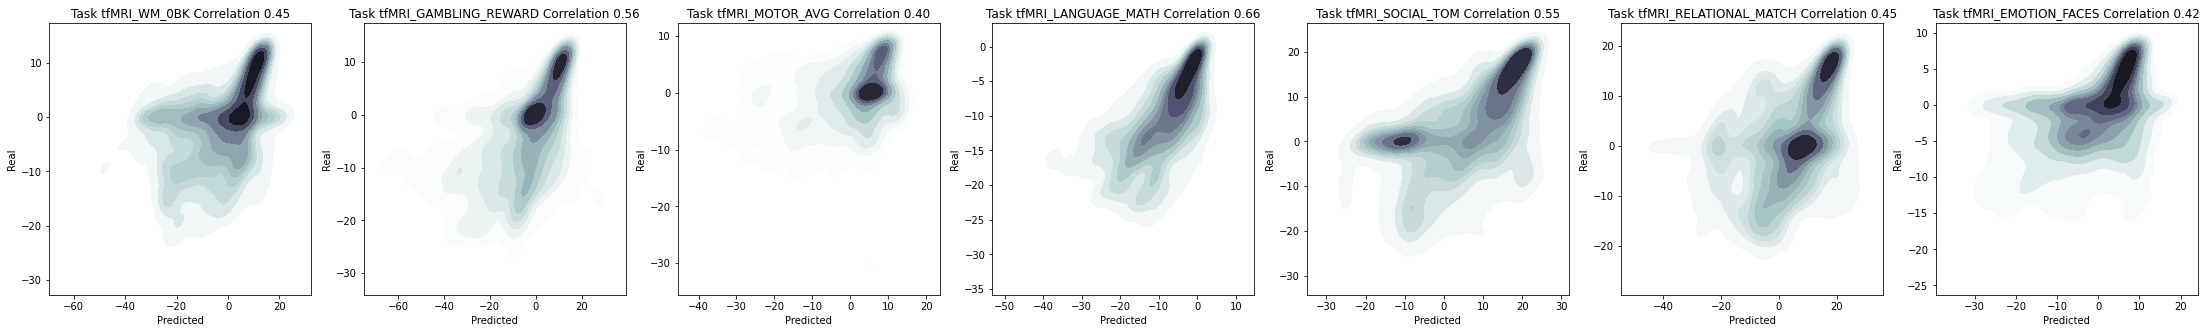

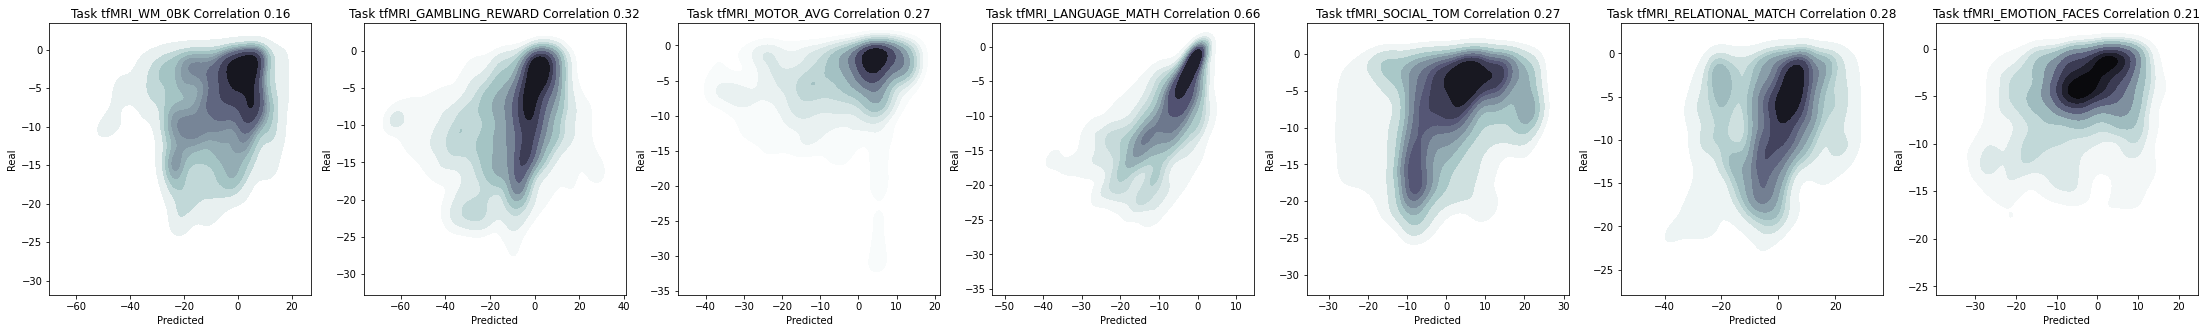

In [28]:
# Visualise real versus predicted activity for each task for each vertex

import seaborn as sns
from scipy import stats
num_tasks=tasks.shape[0]
fig, axes = plt.subplots(1,num_tasks, figsize=(5.5* num_tasks , 5))
count=0
for taskID, task in enumerate(tasks):
    threshUpper= np.percentile(left_brain[:,task], 75, axis=0)
    

    pos_index=left_brain[:,task]>threshUpper
    neg_index=left_brain[:,task]<threshUpper

    ax = axes[count]
    clust_data = np.ravel(LKPredAllTasks[neg_index, taskID])*-1
    task_data = np.ravel(left_brain[neg_index, task])*-1
    s_r=format(stats.spearmanr(clust_data,task_data)[0], '.2f')
    df = pd.DataFrame({"LKPredAllTasks": clust_data*-1, "left_brain": task_data*-1})
    sns.kdeplot(data=df, x="LKPredAllTasks", y="left_brain",fill=True,ax=ax,cmap="bone_r")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    ax.set_title(f"Task {taskNames[tasks[taskID]]} Correlation {s_r}")

    count=count+1

plt.savefig('EachTaskScatterRealPred_lt_75pcPredNeg.png')
    
fig2, axes = plt.subplots(1,num_tasks, figsize=(5.5 * num_tasks, 5))
count=0
for taskID, task in enumerate(tasks):
    
    #threshLower= np.percentile(left_brain[:,task], 50, axis=0)
    neg_index=left_brain[:,task]<0
    
    
    ax = axes[count]
    clust_data = np.ravel(LKPredAllTasks[neg_index, taskID])
    task_data = np.ravel(left_brain[neg_index, task])
    s_r=format(stats.spearmanr(clust_data,task_data)[0], '.2f')
    df = pd.DataFrame({"LKPredAllTasks": clust_data, "left_brain": task_data})
    sns.kdeplot(data=df, x="LKPredAllTasks", y="left_brain",fill=True,ax=ax,cmap="bone_r")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    ax.set_title(f"Task {taskNames[tasks[taskID]]} Correlation {s_r}")

    count=count+1

plt.savefig('EachTaskScatterRealPred_ltPreNeg_0.png')


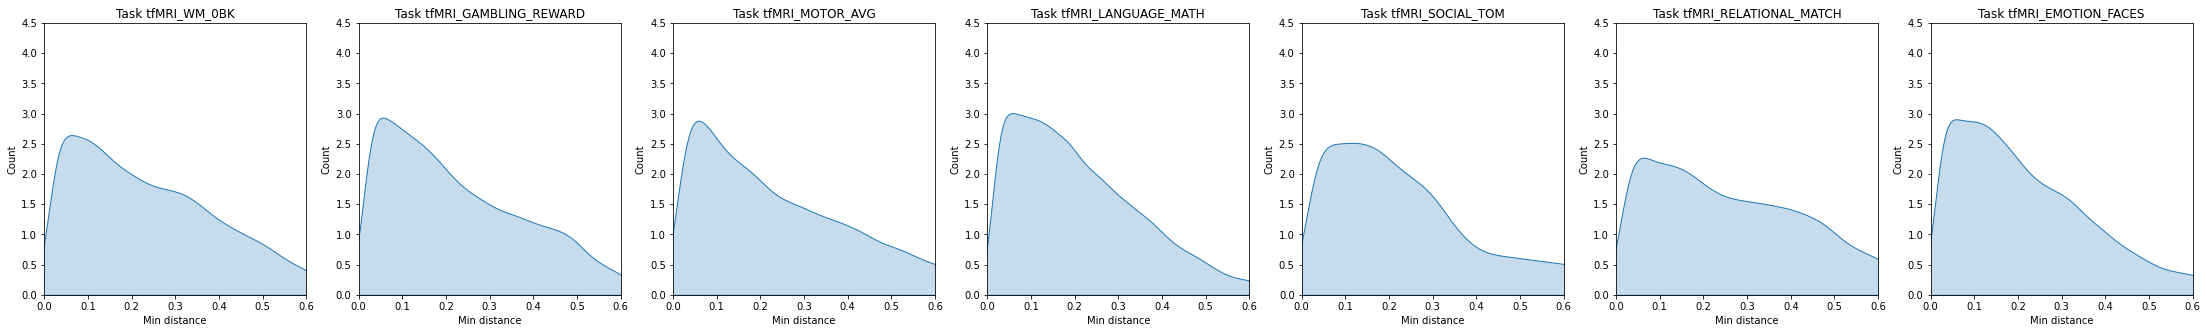

In [29]:
# Calculate distances for each out of mask vertex to nearest mask vertex based on Haversine distance on sphere

from sklearn.metrics import DistanceMetric

num_tasks=tasks.shape[0]
fig, axes = plt.subplots(1,num_tasks, figsize=(5.5* num_tasks , 5))
count=0
for i in range(len(tasks)):
    ax = axes[count]
    taskID=i
    task=tasks[taskID]
    threshUpper= np.percentile(left_brain[:,task], 75, axis=0)
    threshLower= np.percentile(left_brain[:,task], 25, axis=0)
    pos_index=left_brain[:,task]>threshUpper
    dist = DistanceMetric.get_metric('haversine')

    DistsExt=dist.pairwise(ptsnew[pos_index,4:6],ptsnew[pos_index==False,4:6])
    #DistsInt=dist.pairwise(ptsnew[pos_index,4:6])
    MinDistsExt=DistsExt.min(axis=0)
    sns.kdeplot(data=MinDistsExt,ax=ax,fill=True,cmap="bone_r")
    ax.set_xlim(xmin=0, xmax=0.6)
    ax.set_ylim(ymin=0, ymax=4.5)
    ax.set_xlabel("Min distance")
    ax.set_ylabel("Count")
    ax.set_title(f"Task {taskNames[tasks[taskID]]}")

    count=count+1

plt.savefig('EachTaskMinDistToPostThresh_PredNeg.png')
    #plt.scatter(MinDistsExt,np.abs(LKPredAllTasks[pos_index==False,taskID]-left_brain[pos_index==False,task]))
    #plt.show()
#MinDistsInt=np.where(DistsInt.min(axis=0)==0,1000,DistsInt)
#MinDistInt=np.where(DistsInt==0,1000,DistsInt).min(axis=0)
